In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Using Neural Network for Dog Breed Identification

#### Jake Williams and Cat Ngo

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/home/jlwilliams/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Importing fast ai libraries.

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Creating PATH to access data.

In [1]:
PATH = "../../data/dogbreeds/"
sz=224

Verifying GPU setup.

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

### Downloading data and setting up directory structure

In [22]:
cd data

In [23]:
mkdir dogbreeds

dogbreeds/  dogscats/


In [43]:
cd ..

/home/jlwilliams


In [78]:
%env KAGGLE_USERNAME=topspinjake #set up the Kaggle API in the enivironmnet

env: KAGGLE_USERNAME=topspinjake #set up the Kaggle API in the enivironmnet


In [40]:
%env KAGGLE_KEY=ceac84d7c57e2aef8b4f562d79e94ddb

env: KAGGLE_KEY=ceac84d7c57e2aef8b4f562d79e94ddb


In [52]:
!kaggle competitions download -c dog-breed-identification #download

  0%|                                                | 0.00/214k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 214k/214k [00:00<00:00, 86.7MB/s]
  0%|                                                | 0.00/318k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 318k/318k [00:00<00:00, 101MB/s]
 95%|██████████████████████████████████████▉  | 329M/346M [00:01<00:00, 224MB/s]
100%|█████████████████████████████████████████| 346M/346M [00:01<00:00, 216MB/s]
 94%|██████████████████████████████████████▋  | 325M/345M [00:01<00:00, 210MB/s]
100%|█████████████████████████████████████████| 345M/345M [00:01<00:00, 224MB/s]


Unzipping the files

In [56]:
!unzip labels.csv.zip

Archive:  labels.csv.zip
  inflating: labels.csv              


In [ ]:
!unzip sample_submission.csv.zip
!unzip test.zip
!unzip train.zip

In [ ]:
rm *.zip #remove zip files

In [79]:
os.listdir(PATH)

['train',
 'sample_submission.csv',
 'labels.csv',
 'valid',
 'tmp',
 'models',
 '.ipynb_checkpoints',
 'test']

**Start separating training data into 120 directories, using csv tools**

In [16]:
import csv

datafile = open("labels.csv","r")
dataread = csv.reader(datafile, delimiter=';')
data = []
for row in dataread: #create list of list from csv file
    data.append(row) 

In [97]:
data[1][0][0:32] #find correct index to get file name

'000bec180eb18c7604dcecc8fe0dba07'

In [17]:
bigDict = {} #create dictionary with keys as dog breed
            # value of each key will be a list that contains the photo id of the breed
for entry in data[1:]:
    imageid = entry[0][0:32] #take image id
    temp_key = entry[0][33:]
    if temp_key in bigDict.keys(): #add id to dictionary if key exists
        bigDict[temp_key].append(imageid)
    else: # if not create new list of keys
        bigDict[temp_key]= [imageid]

In [16]:
len(bigDict.keys()) #sanity check

120

In [ ]:
!mkdir valid # make validation set

**Create 120 directories in train and valid set**

In [115]:
import os

for key in bigDict.keys(): 
    directory = "../../data/dogbreeds/valid/" + str(key)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
for key in bigDict.keys(): 
    directory = "../../data/dogbreeds/train/" + str(key)
    if not os.path.exists(directory):
        os.makedirs(directory)
    

Moving images into their respective folders by breed. 

In [117]:
for key in bigDict.keys():
    for pid in bigDict[key]:
        current = "../../data/dogbreeds/train/" + str(pid) + ".jpg"
        move = "../../data/dogbreeds/train/" + str(key) + "/" + str(pid) + ".jpg"
        os.rename(current, move)
    

Moving 10% of images from train to valid. 

In [20]:
for key in bigDict.keys():
    length = (len(bigDict[key]))
    target = (length//10)
    for i in range(0, target):
        pid = bigDict[key][i]
        current = "../../data/dogbreeds/train/" + str(key) + "/" + str(pid) + ".jpg"
        move = "../../data/dogbreeds/valid/" + str(key) + "/" + str(pid) + ".jpg"
        os.rename(current, move)

Delete ipynb_checkpoints in valid and training

In [18]:
import shutil

for key in bigDict.keys():
    train = "../../data/dogbreeds/train/" + str(key) + "/" + ".ipynb_checkpoints"
    valid = "../../data/dogbreeds/valid/" + str(key) + "/" + ".ipynb_checkpoints"
    if os.path.exists(train):
        shutil.rmtree(train)
    if os.path.exists(valid):
        shutil.rmtree(valid)

Check through if our directories work

In [12]:
files = os.listdir(f'{PATH}valid/walker_hound')[:5]
files

['0067dc3eab0b3c3ef0439477624d85d6.jpg',
 '015b363b062f602e7ec04ce28e640d05.jpg',
 '03b7320cf8054e57b499e01d1cde0644.jpg',
 '04254919cc15c6867cccfd738a926999.jpg',
 '03564fbb4aba93dd80e5c7cd76f28d28.jpg']

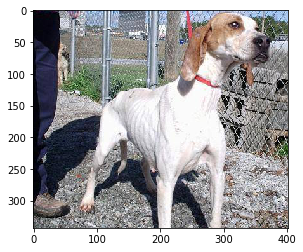

In [13]:
img = plt.imread(f'{PATH}valid/walker_hound/{files[0]}')
plt.imshow(img);

### Training the neural network

In [23]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy   
    0      1.910328   0.922873   0.804752  
    1      0.988864   0.617924   0.839876  
    2      0.751971   0.547298   0.854339  
    3      0.625778   0.502486   0.846074  
    4      0.582544   0.47715    0.850207  



[array([0.47715]), 0.8502066115702479]

Find the learning rate

In [24]:
lrf=learn.lr_find()

 82%|████████▏ | 119/145 [00:02<00:00, 51.11it/s, loss=0.881]


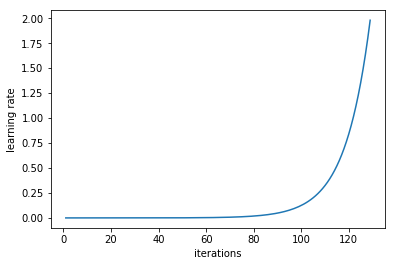

In [25]:
learn.sched.plot_lr()

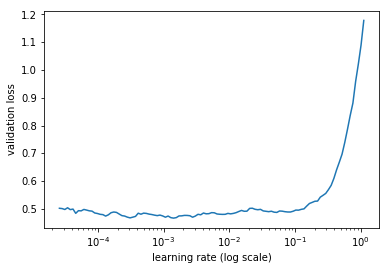

In [26]:
learn.sched.plot()

We will use a learning rate at 0.03, since there's a little peak just before it on the graph above.

In [27]:
learn.fit(0.03, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.607506   0.497965   0.832645  
    1      0.514894   0.487466   0.847107  
    2      0.456781   0.488147   0.84814   



[array([0.48815]), 0.8481404958677686]

In [28]:
learn.fit(0.03, 10) #try it with 10 epochs to see if accuracy improves

epoch      trn_loss   val_loss   accuracy   
    0      0.390806   0.472285   0.849174  
    1      0.355472   0.479572   0.859504  
    2      0.326652   0.480554   0.840909  
    3      0.297245   0.486793   0.853306  
    4      0.28059    0.49581    0.859504  
    5      0.241475   0.490651   0.850207  
    6      0.225518   0.486288   0.868802  
    7      0.22489    0.487836   0.858471  
    8      0.200197   0.516172   0.856405  
    9      0.198749   0.52453    0.84814   



[array([0.52453]), 0.8481404958677686]

We see that with this model, the peak is 0.868 and it varies between 0.84 to 0.86.<br/>
Now we will try out data augmentation to see if the model improves.

In [29]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [30]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [31]:
learn.fit(0.03, 6)

epoch      trn_loss   val_loss   accuracy   
    0      1.204501   0.554225   0.853306  
    1      0.749497   0.500402   0.840909  
    2      0.592555   0.477399   0.853306  
    3      0.488626   0.457251   0.862603  
    4      0.432303   0.459219   0.855372  
    5      0.384757   0.445965   0.871901  



[array([0.44597]), 0.871900826446281]

We update only the last layer of the neural net and test the new model.

In [33]:
learn.precompute=False
learn.fit(0.03, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.467478   0.438961   0.871901  
    1      0.459202   0.434603   0.867769  
    2      0.451734   0.431432   0.866736  



[array([0.43143]), 0.8667355371900827]

We see that this has slightly higher accuracy then previous model. <br/>
Then, we save the last layer

In [34]:
learn.save('lastlayer_all')

### Apply our Neural Net to Test Dataset

Rewrite data so we can have the test_ds.fnames variable

In [39]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),
                                      test_name="test")
data.test_ds.fnames[:10]

['test/f1705303b30da3a48db2a5f34376b947.jpg',
 'test/a9b79809bc1301f8d148e15bfecf6485.jpg',
 'test/cc94a3bb7191a247f59e1540d8430c93.jpg',
 'test/f7b489a38302afc010d8a386a1b7d085.jpg',
 'test/6e21c96226078576342ca66e25eb1aa9.jpg',
 'test/f16eed64196d24c423f0a68d7ebf287d.jpg',
 'test/635f438cd68b65dd6b4e100b338015fd.jpg',
 'test/b827855f566b9569fd668d990854ad0b.jpg',
 'test/5d1e83adfaac47f754f16021615fc8bf.jpg',
 'test/8a08c0b0d4554a270f66f2f16278ee70.jpg']

Learn the model with new data

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [00:59<00:00,  1.55it/s]


In [45]:
learn.fit(0.03, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.494233   0.456126   0.85124   
    1      0.429466   0.469606   0.845041  
    2      0.398015   0.461725   0.857438  



[array([0.46173]), 0.8574380165289256]

In [46]:
log_preds, y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)

In [67]:
probs.shape

(10357, 120)

Create a csv file to save the predictions in.

In [73]:
df = pd.DataFrame(probs[:,:])
df.columns = sorted(bigDict.keys())

In [74]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [75]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f1705303b30da3a48db2a5f34376b947,5.555785e-08,5.225971e-06,5.287013e-06,5.579778e-05,2.511829e-05,4.958300e-07,2.175696e-07,6.767115e-08,5.233302e-08,...,4.587970e-07,7.305449e-08,3.768059e-02,4.865425e-06,9.100564e-01,1.042503e-07,4.939250e-08,5.445872e-05,1.940542e-08,9.974800e-08
1,a9b79809bc1301f8d148e15bfecf6485,2.387976e-04,3.277510e-06,6.048497e-05,3.250494e-06,5.576019e-06,1.432715e-04,4.138503e-05,1.377809e-06,3.111324e-05,...,4.507748e-05,5.674780e-05,2.834180e-06,2.860520e-04,4.961612e-05,6.773714e-06,6.713468e-03,3.575592e-06,5.773440e-06,2.604240e-06
2,cc94a3bb7191a247f59e1540d8430c93,4.569387e-05,2.672956e-05,9.958224e-06,1.700333e-05,1.722867e-06,1.256406e-02,1.905265e-05,5.582388e-06,2.600331e-06,...,2.373899e-05,1.242249e-06,2.370823e-06,7.453410e-06,9.287456e-07,2.778770e-05,6.704650e-06,5.040491e-07,3.972234e-06,1.608229e-05
3,f7b489a38302afc010d8a386a1b7d085,9.849969e-07,3.829823e-07,1.268582e-07,3.644075e-07,4.927984e-07,1.579193e-02,4.089266e-07,1.357407e-06,1.009061e-06,...,2.464604e-07,1.690351e-08,9.324637e-08,2.077138e-06,1.107292e-07,1.744992e-06,7.104276e-08,8.110197e-08,2.889216e-08,2.530137e-07
4,6e21c96226078576342ca66e25eb1aa9,1.710507e-04,1.210962e-05,4.882670e-06,1.941545e-05,3.711567e-07,5.404265e-07,5.426456e-07,1.377164e-07,5.883668e-08,...,3.898665e-07,4.042787e-08,2.469982e-06,4.879158e-07,8.922333e-06,1.156762e-07,2.263589e-06,2.242700e-05,2.310027e-06,9.325065e-06


Export data frame to csv

In [76]:
SUBM = f'../../out/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogbreeds.gz', compression='gzip', index=False)

#### Result for Kaggle submission<br/>
![](DogBreedSubmission.png)